In [1]:
from hopper import Hopper1
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import mujoco as mj
import multiprocessing

In [2]:
xml_path = "./xml/hopper1/scene2.xml"
# 储存所有数据的列表，不同批次的实验使用不同的二维列表
class AllData:
    def __init__(self) -> None:
        self.all_time_datas = []
        self.all_kinetic_energy_datas = []
        self.all_potential_energy_datas = []
        self.all_total_energy_datas = []
        self.all_cm_height_datas = []
        self.all_cm_velocity_datas = []
        self.all_cm_acceleration_datas = []
        self.all_tenser_stiffness_datas = []

## 改变弹簧刚度实验
改变弹簧刚度，从50加到400，测试
改进：使用了多进程加快实验速度

In [3]:
num_of_test = 20 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/scene2.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_stiffness[0] = 50 + i * 20
    print(f'第{i+1}次实验，弹簧刚度为{sim.model.tendon_stiffness[0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.simend = 1.5
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集离地前的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[:index], sim.hopperdata.kinetic_energy_datas[:index],
               sim.hopperdata.potential_energy_datas[:index],sim.hopperdata.total_energy_datas[:index],
               sim.hopperdata.cm_pos_z_datas[:index], sim.hopperdata.cm_vel_z_datas[:index],
               sim.hopperdata.cm_acc_z_datas[:index], [sim.model.tendon_stiffness[0]]*index))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_stiffness_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧刚度为50.0。

第2次实验，弹簧刚度为70.0。

第3次实验，弹簧刚度为90.0。
第4次实验，弹簧刚度为110.0。


第5次实验，弹簧刚度为130.0。

第6次实验，弹簧刚度为150.0。
第7次实验，弹簧刚度为170.0。




第8次实验，弹簧刚度为190.0。
第9次实验，弹簧刚度为210.0。


第10次实验，弹簧刚度为230.0。



### 离开地面前质心高度和速度的关系
基本是正相关

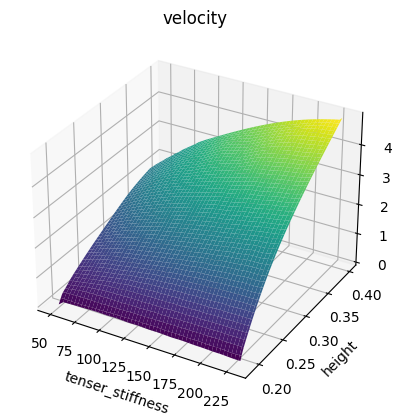

In [4]:
# 剔除None的数据
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
z = [item for sublist in allData.all_cm_velocity_datas for item in sublist]
x = [item for sublist in allData.all_tenser_stiffness_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='cubic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('tenser_stiffness')
ax.set_ylabel('height')
ax.set_title('velocity')
plt.show()

### 离开地面前质心高度和加速度的关系
随着质心高度增大，质心加速度先急剧增大后平缓增大，最后减小

随着弹簧刚度的增大，加速度最大值提前

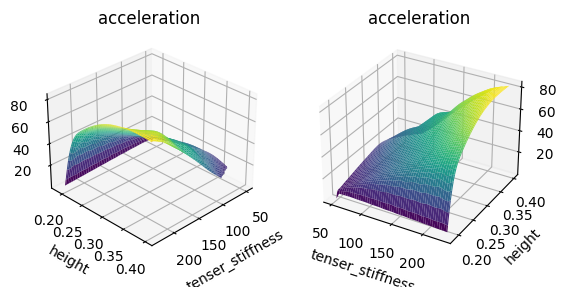

In [5]:
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_stiffness_datas for item in sublist]
z = [item for sublist in allData.all_cm_acceleration_datas for item in sublist]
# 剔除None的数据
indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='cubic')
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_stiffness')
ax1.set_ylabel('height')
ax1.set_title('acceleration')
ax1.view_init(elev=30, azim=45)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, cmap='viridis')
ax2.set_xlabel('tenser_stiffness')
ax2.set_ylabel('height')
ax2.set_title('acceleration')
plt.show()
